In [41]:
import os
import json
import pandas as pd
from datetime import datetime, timezone
from pathlib import Path

from traffic.core import Traffic

from utils.process_audio import ATCFileMeta, AudioCatalog
from pydub import AudioSegment

output_dir = "outputs/20250831"

In [42]:
def load_transcripts_json(path):
    with open(path) as f:
        data = json.load(f)
    # convert iso → datetime
    return [
        [(datetime.fromisoformat(ts), text) for ts, text in transcripts]
        for transcripts in data
    ]

def load_callsign_comms_json(path):
    with open(path) as f:
        data = json.load(f)
    # convert iso → datetime
    return {
        cs: [
            {
                **entry,
                "timestamp": datetime.fromisoformat(entry["timestamp"])
            }
            for entry in entries
        ]
        for cs, entries in data.items()
    }
    
def load_audio_catalog_from_json(path: str | Path,
                                    target_sr: int = 16000,
                                    mono: bool = True) -> AudioCatalog:
        """
        Reload a catalog from JSON (previously saved with only ATCFileMeta).
        Returns list of (ATCFileMeta, AudioSegment).
        """
        with open(path, "r") as f:
            data = json.load(f)

        catalog: AudioCatalog = []
        for entry in data:
            meta = ATCFileMeta(
                sector=entry["sector"],
                dt=datetime.fromisoformat(entry["dt"]).replace(tzinfo=timezone.utc),
                freq_hz=int(entry["freq_hz"]),
                freq_mhz=float(entry["freq_mhz"]),
                ext=entry["ext"],
                original_name=entry["original_name"],
                path=entry["path"],
            )

            # reload audio
            seg = AudioSegment.from_file(meta.path)
            if mono:
                seg = seg.set_channels(1)
            if target_sr:
                seg = seg.set_frame_rate(target_sr)

            catalog.append((meta, seg))

        # sort by timestamp just in case
        catalog.sort(key=lambda item: item[0].dt)
        return catalog

In [43]:
# catalog = load_audio_catalog_from_json(os.path.join(output_dir, "catalog.json"))
callsigns_coms = pd.read_parquet(os.path.join(output_dir, "callsign_comms.parquet"))
adsb = Traffic.from_file(os.path.join(output_dir, "adsb.parquet"))
transcripts = load_transcripts_json(os.path.join(output_dir, "transcripts.json"))

In [50]:
transcripts

[[(datetime.datetime(2025, 8, 31, 0, 0, 1, tzinfo=datetime.timezone.utc),
   'three five'),
  (datetime.datetime(2025, 8, 31, 0, 1, 4, tzinfo=datetime.timezone.utc),
   'zero nine one zero nine siberia nine five five'),
  (datetime.datetime(2025, 8, 31, 0, 1, 50, tzinfo=datetime.timezone.utc),
   'lot three quebec one one mike golf flight level three eight zero'),
  (datetime.datetime(2025, 8, 31, 0, 1, 55, tzinfo=datetime.timezone.utc),
   'channex one one mike golf lower than five'),
  (datetime.datetime(2025, 8, 31, 0, 2, 6, tzinfo=datetime.timezone.utc),
   'praha good morning united nine one flight level three six zero united nine one and then final request'),
  (datetime.datetime(2025, 8, 31, 0, 2, 15, tzinfo=datetime.timezone.utc),
   'direct to vlm csa nine one'),
  (datetime.datetime(2025, 8, 31, 0, 3, 5, tzinfo=datetime.timezone.utc),
   'three five'),
  (datetime.datetime(2025, 8, 31, 0, 3, 17, tzinfo=datetime.timezone.utc),
   'three zero'),
  (datetime.datetime(2025, 8, 31

In [52]:
callsigns_coms.tail(10)

,callsign,timestamp,sentence,detected,score,matched
6025,None,2025-08-31 23:57:12+00:00,climbing five,None,NaN,False
6026,EXS6AH,2025-08-31 23:58:58+00:00,navigator six alfa hotel we re just getting li...,navigator six alfa hotel,0.75,True
6027,EXS6AH,2025-08-31 23:59:07+00:00,channex six alfa hotel earlier we had report o...,channex six alfa hotel,1.00,True
6028,EXS79WU,2025-08-31 23:59:19+00:00,channex seven nine whiskey uniform austrian,channex seven nine whiskey uniform austrian,0.90,True
6029,EXS79WU,2025-08-31 23:59:23+00:00,channex seven nine whiskey uniform go ahead,channex seven nine whiskey uniform,1.00,True
6030,EXS79WU,2025-08-31 23:59:27+00:00,yes seven nine whiskey uniform any turbulence,yes seven nine whiskey uniform,0.83,True
6031,None,2025-08-31 23:59:29+00:00,yeah we have just experienced occasional moder...,None,NaN,False
6032,None,2025-08-31 23:59:38+00:00,ok that copied that what was reported before a...,None,NaN,False
6033,EXS79WU,2025-08-31 23:59:46+00:00,roger thank you channex seven nine whiskey uni...,channex seven nine whiskey uniform channex six...,0.89,True
6034,None,2025-08-31 23:59:57+00:00,ok we can expect a report,None,NaN,False


****
# Identified Communications
****

Good conversations for the paper:
- SAS66P on 25/08
- UAE59T on 31/08
- LOT274 on 31/08
- AFR75BQ on 31/08
- UAL933 on 31/08
- DLH8P  on 31/08

Avec Heading insturctions on 31/08:
- DLH8P, LOT274, RYR7DP, UAL933, AFR74BQ, (~EXS321P)


In [31]:
callsigns_coms

,callsign,timestamp,sentence,detected,score,matched
0,None,2025-08-31 00:00:01+00:00,three five,three five,NaN,False
1,None,2025-08-31 00:01:04+00:00,zero nine one zero nine siberia nine five five,zero nine one zero nine siberia nine five five,NaN,False
2,None,2025-08-31 00:01:50+00:00,lot three quebec one one mike golf flight leve...,lot three quebec one one mike,NaN,False
3,EXS11MG,2025-08-31 00:01:55+00:00,channex one one mike golf lower than five,channex one one mike,0.74,True
4,None,2025-08-31 00:02:06+00:00,praha good morning united nine one flight leve...,united nine one,NaN,False
...,...,...,...,...,...,...
6030,EXS79WU,2025-08-31 23:59:27+00:00,yes seven nine whiskey uniform any turbulence,yes seven nine whiskey uniform,0.83,True
6031,None,2025-08-31 23:59:29+00:00,yeah we have just experienced occasional moder...,None,NaN,False
6032,None,2025-08-31 23:59:38+00:00,ok that copied that what was reported before a...,None,NaN,False
6033,EXS79WU,2025-08-31 23:59:46+00:00,roger thank you channex seven nine whiskey uni...,channex seven nine whiskey uniform channex six...,0.89,True


In [32]:
len(callsigns_coms.query("matched == True")) / len(callsigns_coms)

0.48732394366197185

In [33]:
callsigns_coms.query("matched == True").callsign.value_counts()

callsign
DLH415     23
DLH419     17
WUK9109    16
DLH846     16
BOX459     14
           ..
CSN347      1
UPS222      1
AAL704      1
HYS711      1
KLM48       1
Name: count, Length: 1277, dtype: int64

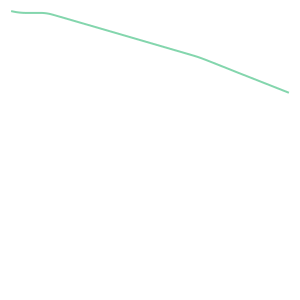

In [39]:
adsb["UAE59T"]

In [40]:
cs = "UAE59T"
cs_conv = callsigns_coms.query(f"callsign == '{cs}'")
for _, l in cs_conv.iterrows():
    print(l["timestamp"], l["sentence"])
# cs_conv.to_csv("DLH8P.csv")

2025-08-31 21:06:20+00:00 good evening emirates five nine tango heavy level three five zero
2025-08-31 21:06:26+00:00 emirates five nine tango good evening identified proceed direct to touch down
2025-08-31 21:09:21+00:00 emirates five nine tango proceed direct to patko
2025-08-31 21:09:30+00:00 that was blocked confirm emirates five nine tango to patko
2025-08-31 21:25:26+00:00 emirates five nine tango contact mare three seven one two eight seven nine zero bye bye one three seven nine zero emirates five nine tango good night


In [ ]:
# start = datetime(2025, 8, 31, 8, 26, 0, tzinfo=timezone.utc)
# stop  = datetime(2025, 8, 31, 8, 58, 0, tzinfo=timezone.utc)

# cond = (start < callsigns_coms.timestamp) & (callsigns_coms.timestamp < stop)
# callsigns_coms[cond].to_csv("test.csv")

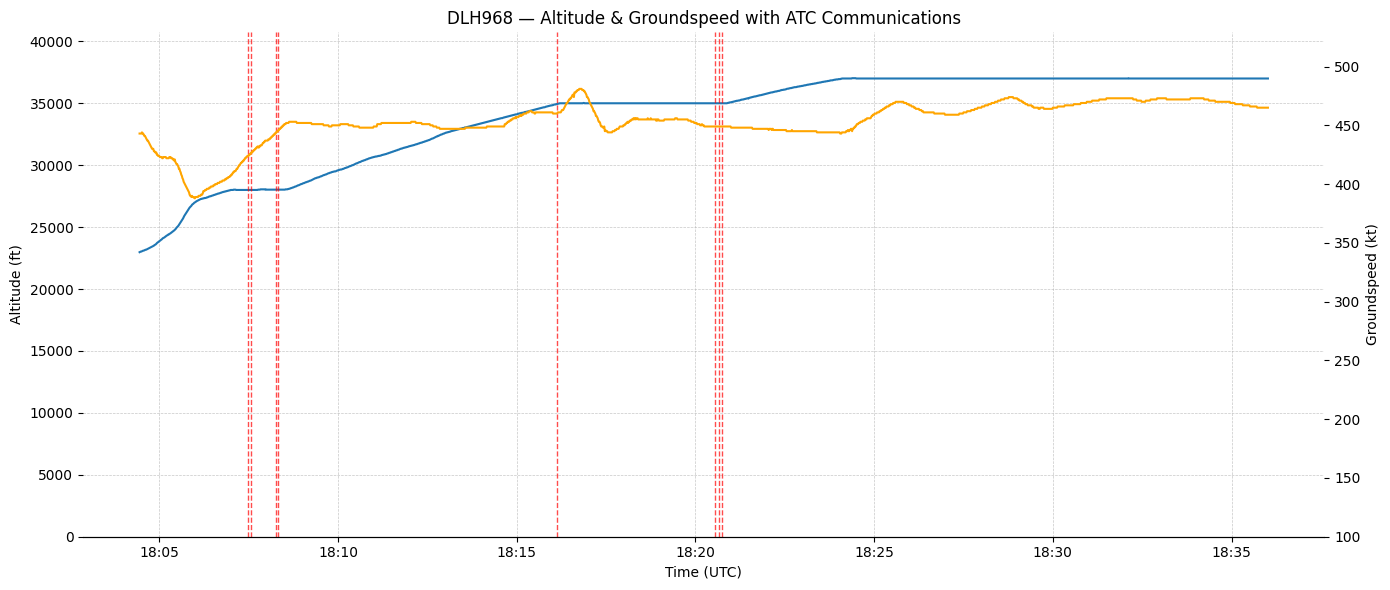

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta

cs = 'LOT274'

comms_df = callsigns_coms.query(f"callsign == '{cs}'").copy()
comms_df["timestamp"] = pd.to_datetime(comms_df["timestamp"], utc=True)
comm_times = sorted(comms_df["timestamp"].dropna().unique())

cmin, cmax = comm_times[0], comm_times[-1]

pad = timedelta(minutes=5)
f = adsb[cs]

df_fl = f.data.copy()
df_fl = df_fl.sort_values("timestamp")

if "altitude" not in df_fl and "baroaltitude" in df_fl:
    df_fl["altitude"] = df_fl["baroaltitude"] * 3.28084  # m -> ft
if "groundspeed" not in df_fl and "velocity" in df_fl:
    df_fl["groundspeed"] = df_fl["velocity"] * 1.94384   # m/s -> kt

# 4) Plot
fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.plot(df_fl["timestamp"], df_fl["altitude"], label="Altitude (ft)")
ax1.set_ylabel("Altitude (ft)")
ax1.set_ylim(0, max(30000, df_fl["altitude"].max() * 1.1))
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

ax2 = ax1.twinx()
ax2.plot(df_fl["timestamp"], df_fl["groundspeed"], label="Groundspeed (kt)", color="orange")
ax2.set_ylabel("Groundspeed (kt)")
ax2.set_ylim(100, max(400, df_fl["groundspeed"].max() * 1.1))

# Vertical markers at each comm
for ts in comm_times:
    ax1.axvline(ts, color="red", linestyle="--", linewidth=1, alpha=0.7)

# # Optional: annotate a few comms (e.g., first 3)
# for _, row in comms_df.head(3).iterrows():
#     ax1.annotate(
#         row["detected"],
#         xy=(row["timestamp"], ax1.get_ylim()[1] * 0.95),
#         xytext=(5, -5),
#         textcoords="offset points",
#         fontsize=9,
#         rotation=0,
#         ha="left", va="top",
#         bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7)
#     )

# X-axis formatting
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.set_xlabel("Time (UTC)")
plt.title("DLH968 — Altitude & Groundspeed with ATC Communications")

# De-clutter spines
for spine in ["top", "right", "left"]:
    ax1.spines[spine].set_visible(False)
    ax2.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()


In [62]:
from ipyleaflet import Marker, Polygon, Rectangle
import math
from shapely.geometry import Polygon as ShapelyPolygon

delta_coords = [
    (53.454167, 3.606111),
    (52.733333, 5.583333),
    (52.663333, 7.168889),
    (51.193611, 5.521389),
    (51.607778, 3.171944),
    (51.480556, 3.171944),
    (51.636944, 2.500000),
    (51.455556, 2.500000),
    (51.500000, 2.000000),
    (51.950556, 2.356389)
]
delta_geom = ShapelyPolygon([(lon, lat) for lat, lon in delta_coords])
W, S, E, N = delta_geom.bounds      
# Add a buffer layer around delta sector
# 1° lat ≈ 111.32 km; 1° lon ≈ 111.32 km * cos(latitude)
buffer_km = 50.0 # Roughly 4min at 400kts
lat_c = delta_geom.centroid.y
deg_lat = buffer_km / 111.32
deg_lon = buffer_km / (111.32 * math.cos(math.radians(lat_c)))

bbox_buffered = (W - deg_lon, S - deg_lat, E + deg_lon, N + deg_lat)  # (west, south, east, north)

m = f.map_leaflet()

for ts in comm_times:
    if f.at(ts) is not None:
        marker = Marker(location=(f.at(ts).latitude, f.at(ts).longitude))
        m.add(marker)

polygon = Polygon(
    locations=delta_coords + [delta_coords[0]],
    color="red",
    fill_color="red",
    fill_opacity=0.2,
    weight=3,
    name="Sector bounds"
)

bbox_rect = Rectangle(
    bounds=((bbox_buffered[1], bbox_buffered[0]), (bbox_buffered[3], bbox_buffered[2])),
    color="orange",
    fill_color="orange",
    fill_opacity=0.1,
    weight=2,
    name="OpenSky bbox"
)

m.add_layer(polygon)
m.add_layer(bbox_rect)
m

Map(center=[52.69536432548175, 4.668353293473562], controls=(ZoomControl(options=['position', 'zoom_in_text', …

****
# Flights with Flight plan
****

In [10]:
# Last message recieved by the NM
flight_plan["timestamp"] = flight_plan["timestamp"].str.replace(
    r" (\d{3})$", r".\1", regex=True
)
flight_plan["timestamp"] = pd.to_datetime(flight_plan["timestamp"])

# Estimated departure time
flight_plan["flightData.flightId.keys.estimatedOffBlockTime"] = flight_plan["flightData.flightId.keys.estimatedOffBlockTime"].str.replace(
    r" (\d{3})$", r".\1", regex=True
)
flight_plan["flightData.flightId.keys.estimatedOffBlockTime"] = pd.to_datetime(flight_plan["flightData.flightId.keys.estimatedOffBlockTime"])

# Estimated arrival time
flight_plan["flightData.estimatedTimeOfArrival"] = flight_plan["flightData.estimatedTimeOfArrival"].str.replace(
    r" (\d{3})$", r".\1", regex=True
)
flight_plan["flightData.estimatedTimeOfArrival"] = pd.to_datetime(flight_plan["flightData.estimatedTimeOfArrival"])

flight_plan.columns

Index(['timestamp', 'flightData.flightId.keys.aircraftId',
       'flightData.flightId.keys.aerodromeOfDestination',
       'flightData.flightId.keys.estimatedOffBlockTime',
       'flightData.flightId.keys.aerodromeOfDeparture',
       'flightData.flightId.id', 'flightData.estimatedTimeOfArrival',
       'flightData.aircraftAddress', 'flightData.icaoRoute'],
      dtype='object')

In [11]:
icao24_with_fp = []

for cs in adsb.icao24:
    if cs.upper() in flight_plan["flightData.aircraftAddress"].values:
        icao24_with_fp.append(cs)
        
cs_with_fp = []

for cs in adsb.callsigns:
    if cs in flight_plan["flightData.flightId.keys.aircraftId"].values:
        cs_with_fp.append(cs)

filtered_coms = callsigns_coms.query(f"callsign.isin({cs_with_fp})")
filtered_coms.to_parquet("outputs/20250825/callsign_communications_flight_plan.parquet")

In [12]:
len(filtered_coms.callsign.unique())

191

In [13]:
filtered_coms.callsign.value_counts()

callsign
AFR1610    10
SAS588      9
SAS4703     9
SAS2773     8
AFR1462     7
           ..
TVF55PJ     1
VOE2119     1
NOZ1487     1
TAY7TL      1
EJU3968     1
Name: count, Length: 191, dtype: int64

In [19]:
filtered_coms.query("score == 1").callsign.value_counts()

callsign
AFR1610    8
SAS588     5
KLM1641    4
RYR6NJ     3
SAS63Y     3
          ..
NOZ97B     1
NOZ1487    1
NSZ4MF     1
AFR67ZC    1
TAY7TL     1
Name: count, Length: 86, dtype: int64

****
# Identified conflict
****

In [15]:
deconf_id = ["AA74425009", "AA74432303",  "AA74433748", "AA74434065", "AA74435697", "AA74437096",  "AA74440384", "AA74442937", "AA74444104", "AA74450790"]
deconf_cs = flight_plan[flight_plan['flightData.flightId.id'].isin(deconf_id)]["flightData.flightId.keys.aircraftId"].values.tolist()

neighbour_id = ["AA74416692", "AA74435999", "AA74457745",]
neighbour_cs = flight_plan[flight_plan['flightData.flightId.id'].isin(neighbour_id)]["flightData.flightId.keys.aircraftId"].values.tolist() + ["AIC129", "BEL5MQ", "ICE520", "ETD918", "QTR64J", "LHX2500", "KLM281"]

In [29]:
deconf_coms = callsigns_coms.query(f"callsign.isin({deconf_cs})")
deconf_coms.to_csv("deconf_coms.csv")

In [27]:
deconf_coms.query("callsign == 'RYR6NJ'")

,callsign,timestamp,sentence,detected,score,matched
2270,RYR6NJ,2025-08-25 09:47:35+00:00,good day ryan air six november juliett flight ...,ryan air six november juliett,1.0,True
2570,RYR6NJ,2025-08-25 09:53:17+00:00,good day ryan air six november juliett flight ...,ryan air six november juliett,1.0,True
2571,RYR6NJ,2025-08-25 09:53:21+00:00,ryan air six november juliett hello direct pepik,ryan air six november juliett,1.0,True


In [30]:
callsigns_coms.query("callsign == 'NSZ4MF'")

,callsign,timestamp,sentence,detected,score,matched
6184,NSZ4MF,2025-08-25 20:25:08+00:00,rednose four mike foxtrot reduce to speed back...,rednose four mike foxtrot,1.00,True
6344,NSZ4MF,2025-08-25 20:16:06+00:00,foxtrot,foxtrot,0.72,True


In [31]:
transcripts

[[(datetime.datetime(2025, 8, 25, 0, 0, 6, tzinfo=datetime.timezone.utc),
   'two two'),
  (datetime.datetime(2025, 8, 25, 0, 0, 15, tzinfo=datetime.timezone.utc),
   'two five'),
  (datetime.datetime(2025, 8, 25, 0, 0, 19, tzinfo=datetime.timezone.utc),
   'three five'),
  (datetime.datetime(2025, 8, 25, 0, 0, 21, tzinfo=datetime.timezone.utc),
   'lufthansa'),
  (datetime.datetime(2025, 8, 25, 0, 0, 27, tzinfo=datetime.timezone.utc),
   'navigator six alfa hotel papa three six two line up channex six alfa hotel identified'),
  (datetime.datetime(2025, 8, 25, 0, 1, 8, tzinfo=datetime.timezone.utc),
   'three three'),
  (datetime.datetime(2025, 8, 25, 0, 1, 19, tzinfo=datetime.timezone.utc),
   'foxtrot'),
  (datetime.datetime(2025, 8, 25, 0, 2, 33, tzinfo=datetime.timezone.utc),
   'three five'),
  (datetime.datetime(2025, 8, 25, 0, 2, 58, tzinfo=datetime.timezone.utc),
   'five five'),
  (datetime.datetime(2025, 8, 25, 0, 3, 21, tzinfo=datetime.timezone.utc),
   'three five'),
  (dat